# Assignment #5

### Group 4

Lars Wrede, Dennis Blaufuss, Nicolas Kepper, Sophie Merl, Philipp Voit

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
import random
import math
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from enum import Enum
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix

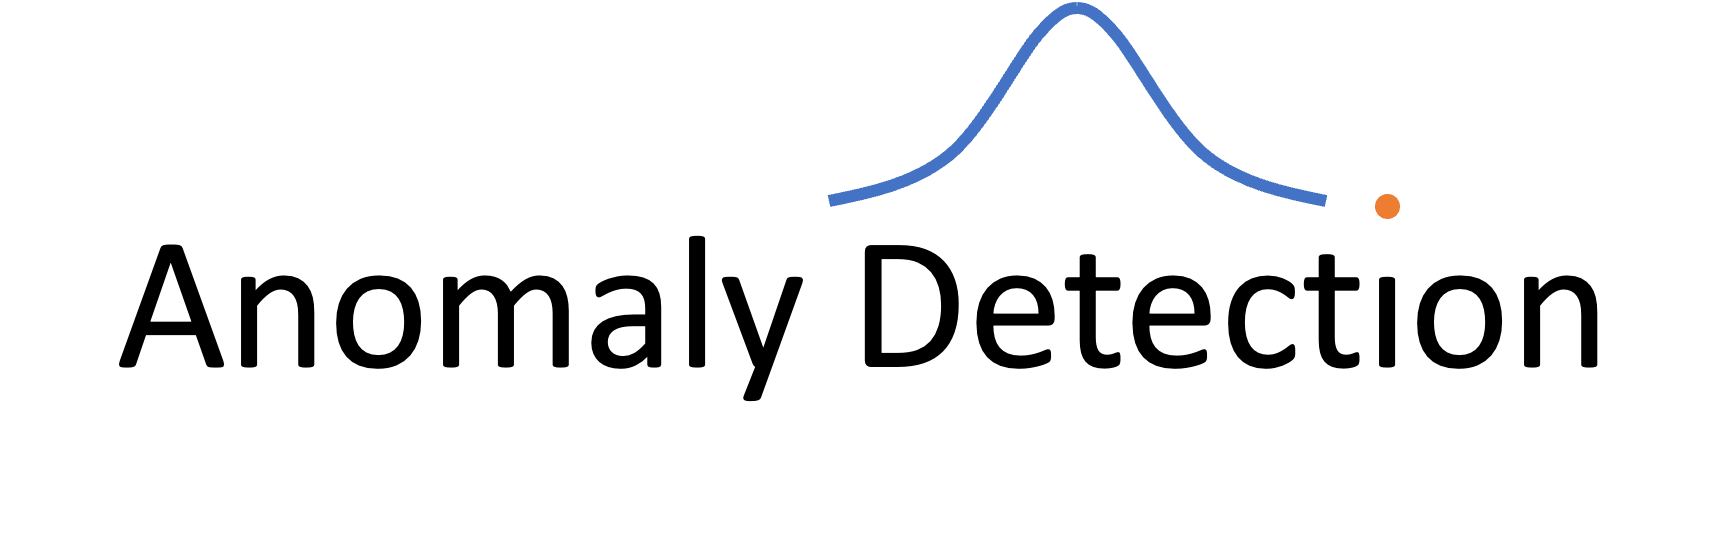

In [2]:
Image(filename='Pic0.png', width=1000)

## Table of Contents

__Introduction__
- Motivation
- Definition of anomalies
- Selected data set
- Shallow vs. deep approaches

__Methods__
- K-means (with preceding PCA)
- Autoencoder
- Feature bagging

__Conclusion__
- Shallow vs. deep approaches
- Deep approches compared

__Bibliography__

# Introduction

### Motivation

One of the first steps in a coherent data analysis is - and should be - the detection of outlying observations, referred to as anomalies or outliers. Although outliers may carry important information, they may lead to biased parameters and thus model mispecification (Ben-Gal, 2005). As we risk deriving aberrant conclusions from our data, we should detect potential anomalies beforehand (Williams et al., 2002; Liu et al., 2004).

Not only for post-processing in data analysis to detect measurement errors, but as an application area of its own, anomaly detection is crucial. For example, unusual purchase patterns can help detect credit card fraud (Pawar et al., 2014), reveal health problems in the context of patient monitoring and alerting (Hausrecht et al., 2013), or help discover outstanding talent in a sports context (Jauhiainen et al., 2019).

Since a variety of methods can be found all across literature and in the depths of the internet, this mini project aims to replicate some of the methods, explain how they work, and discuss weaknesses and strenghts of mentioned methods.

### Definition of anomalies

According to Hawkins (1980) an anomaly is defined as “an observation that deviates so much from other observations as to arouse suspicion that it was generated by a different mechanism”, where mechanism refers to a statistical process. Or in the words of Barnett & Lewis (1994), an “outlying observation, or outlier, is one that appears to deviate markedly from other members of the sample in which it occurs”.
For this mini-project, we will use *anomaly* and *outlier* as synonyms.

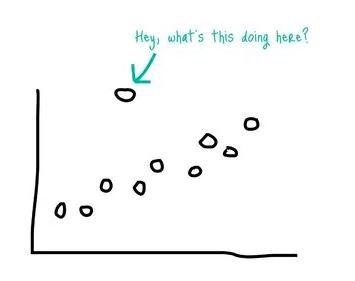

In [3]:
Image(filename='Pic1.jpeg') #figure 1

### Selected data set

Application scenarios may have training data for either exclusively abnormal or normal data (semi-supervised scenario), may have training data for both (supervised scenario), or no training data at all may exist (unsupervised scenario). In practice, we mostly deal with the unsupervised scenario as oftentimes, labeled anomalous data is non-existent (Ruff et al., 2021). In the first variant if we train our model only with the normal data it is often referred to as novelty detection as well.

However, in order to evaluate our methodical approaches and to eventually judge which approach did best, we selected the artificial dataset *synthetic*. This dataset has no specific context and serves only illustrative purposes.

The _synthetic_ dataset consists of 11 columns, 10 dimensions and one column which indicates whether a row is considered anomalous. Exactly 10 percent are outliers.

Let's have a quick glance at _synthetic_:

In [3]:
# loading the dataset
data = pd.read_csv("./synthetic.csv")

# checking data shape
row, col = data.shape
print(f'There are {row} rows and {col} columns') 
data

There are 1000 rows and 11 columns


,0,1,2,3,4,5,6,7,8,9,outlier
0,0.435518,0.038492,0.551343,0.140049,0.899545,0.588684,0.299706,0.245713,0.367375,0.452970,no
1,0.633197,0.034490,0.319406,0.879141,0.163079,0.184356,0.160583,0.104973,0.294980,0.429709,no
2,0.421558,0.299824,0.602220,0.521654,0.954621,0.547448,0.882898,0.586641,0.840204,0.212529,no
3,0.817491,0.647528,0.046214,0.487270,0.053872,0.817499,0.390589,0.394750,0.736854,0.442689,yes
4,0.291513,0.474018,0.065267,0.410573,0.903696,0.466520,0.196878,0.165370,0.297764,0.467911,no
...,...,...,...,...,...,...,...,...,...,...,...
995,0.088368,0.402631,0.726744,0.053558,0.920036,0.599621,0.132750,0.119502,0.251470,0.482979,no
996,0.709031,0.869773,0.563853,0.667340,0.144001,0.116051,0.352950,0.372501,0.343832,0.648546,no
997,0.281746,0.523779,0.290838,0.837198,0.079527,0.166336,0.468142,0.545292,0.352506,0.686788,no
998,0.159682,0.825127,0.716445,0.069445,0.032148,0.654702,0.028203,0.886761,0.165482,0.116204,yes


Furthermore, we will do a general preprocssing. The different methods may add onto that if required. For two of the algorithms we take an unsupervised approach and only use the labels to test the algorithms in the end. For the autoencoder on the otherhand we utilize novelty detection. Thus, we need to split our data into test and training sets. Adding onto that, we drop the outliers in our training set.

To round our preprocessing off, we scale our data for both cases as well as it is usally done.

In [4]:
TARGET = 'outlier'
data[TARGET] = data[TARGET].map(lambda x: 1.0 if x == 'yes' else 0.0)
features = data.drop(TARGET, axis=1)
y_true = data[TARGET]

# Let's scale the features first
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = pd.DataFrame(min_max_scaler.fit_transform(features.copy()))

# For the AE we need a data split (novelty detection)
x_train, x_test, y_train, y_test = train_test_split(
    features, y_true, test_size=0.2, stratify=y_true
)

train_index = y_train[y_train == 0].index
train_data = x_train.loc[train_index]
train_data_outliers = x_train.loc[~x_train.index.isin(train_index)]

min_max_scaler_ae = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler_ae.fit_transform(train_data.copy())
x_train_scaled_outliers = min_max_scaler_ae.transform(train_data_outliers.copy())
x_test_scaled = min_max_scaler_ae.transform(x_test.copy())

### Shallow vs. deep approaches

In order to detect outliers, classical (shallow) unsupervised approaches include Principal Component Analysis (PCA), k-Means, K-nearest neighbour algorithms, Kernel Density Estimation (KDE) and, if applicable, combinations.

As data sets from various disciplines tend to grow significantly in size and in complexity, *deep* (aka multi-layered) learning methods have gained in interest. Deep approaches include deep one-class classification, self-supervised methods as well as deep autoencoder variants and feature bagging as an ensemble learning method.

In contrast to shallow methods, deep-learning methods are successful as they can be capable of providing a meaningful representation of complex and multi-dimensional data. Here, the feature map is not fixed a priori but a feature map of the data is learned (Ruff et al., 2021).

## Methods

For our mini-project, we selected three methods:
1. K-means with preceding PCA,
2. an autoencoder and
3. an ensemble learning technique: feature bagging.

For a fair comparison, we will evaluate the methods on the following - by now well known - metrics:
1. F1-Score
2. Precision
3. Recall
4. Accuracy

### K-Means (with preceding PCA)

As a clustering method, K-means aims to find $K$ clusters within a data set. The algorithm ensures that the clusters are as far away from each other as they can be while the elements per cluster are as close as possible (local Minimum). Data points which surpass a defined threshold distance to one of the $K$ clusters must be regarded as outliers.

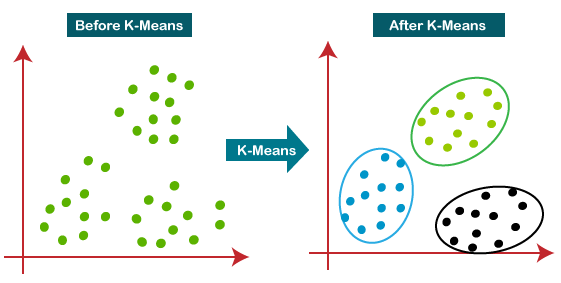

In [6]:
Image(filename='Pic2.png') #figure 2

As we have 10 dimensions, we reduce the dimensionality using PCA beforehand.

In [5]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

# Results from pca.components_
dataset_pca = pd.DataFrame(abs(pca.components_), columns=features_scaled.columns, index=['PC1', 'PC2'])
# print('\n\n', dataset_pca)

print("\n---------------- Most important features -------------------------")
print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())
print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print("------------------------------------------------------------------")

# Creating a DataFrame
data_pca = pd.DataFrame(pca_result, columns=["PC1", "PC2"])

Explained variation per principal component: [0.27295897 0.21650858]
Cumulative variance explained by 2 principal components: 48.95%

---------------- Most important features -------------------------
As per PC 1:
 4    0.707630
5    0.660908
Name: PC1, dtype: float64


As per PC 2:
 6    0.645948
7    0.306335
8    0.555716
9    0.341192
Name: PC2, dtype: float64
------------------------------------------------------------------


Reducing the number of dimensions from 10 to 2, allows us to better visualize our results, but mainly we do it because K-means clustering performs better in lower dimensional datasets. We still explain nearly 50% of the variation in our dataset with only 2 dimensions. PCA as a multivariate method analyzes data and extracts important information (Abdi & Williams, 2010). The principal components serve as summary indices by capturing most information in the dataset.

#### Let's have a look at our comprised data

Text(0, 0.5, 'PC2')

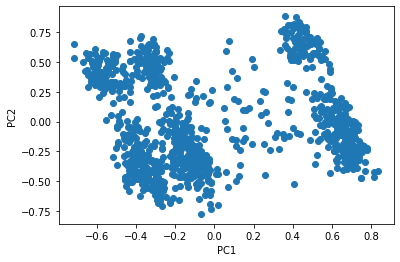

In [8]:
# plotting data set
plt.scatter(*zip(*pca_result))
plt.xlabel("PC1")
plt.ylabel("PC2")

We can already see that there are 4 clusters that we want to determine and where potential outliers might be.

#### The K-means Algorithm

The basic idea behind K-means is that the algorithm starts with a guess at where the "center" of each of the $K$ clusters is in the data.  This center point is called a <i>centroid</i>. So, the first step is to initialize a value for $K$ number of <i>centroids</i>, one for each of the $k = 1, 2, ..., K$ clusters you want to group the data by.  These centroids are points in the $n$-dimensional space of the data, determined by the $n$-dimensions of the features (Zimek et al., 2012).

In [6]:
def initializeCentroids(X, K):
    """
    inputs:
       :X:     training data
       :K:     number of clusters
    outputs:
       an array for a random initial position of the K centroids in n-dimensions
    """

    init_centroids = np.random.permutation(X.shape[0])

    return X[init_centroids[:K], :]

The next step is to assign each data point to the nearest centroid.

In [7]:
def findNearestCentroid(X, centroids):
    """
       input:
            :X:              np.array, an numpy array of features 
            :centroids:      np.array, an numpy array of centroids
       
       output: 
            :cIndex:         np.array, an (m x 1) array
    """
    # :K:  int (the number of centroids)
    K = len(centroids)

    # :distance: an np.array (stores the squared Euclidean distance)
    distance = np.zeros((X.shape[0], K))

    # for each training example, compute the squared Euclidean distance to each centroid
    for k in range(K):
        distance[:,k] = np.sum((X - centroids[k])**2, axis = 1)

    # cIndex is the nearest centroid
    cIndex = np.argmin(distance, axis=1)
    
    return cIndex  

Now, based on all the assigned data points the centroids coordinates are calculated newly to be in the center of all the assigned points.

In [8]:
def computeCentroids(X, cIndex, K):
    """
     inputs:
        :X:           an np.array, representing the training data 
        :cIndex:      an np.array, the output of the function findNearestCentroid()
        :K:           an integer, representing the number of clusters
    output: 
        :centroids: an np.array, stores the mean average assigned to each cluster centroid k (1 to K) by cIndex.
    """
    m, n = X.shape
    
    # initialize centroids to zeros.
    centroids = np.zeros((K,n))

    # updates the "location" of each centroid by calculating the mean average of the elements
    for k in range(K):

        # indx is an array of Boolean values to filter the training set by each cluster
        indx = k == cIndex

        # calculates the average mean value of those elements of X assigned to cluster k by cIndex
        centroids[k,:] = np.mean(X[indx,:], axis=0)
    
    return centroids

Lastly, we put the three steps from above together and loop through step 2 and 3 for *max_iters* iterations. Furthermore, we added an option to plot the process of finding our clusters.

In [9]:
def kMeans(X, initial_centroids, max_iters, plot_on = True):
    """
     inputs:
        :X:                     np.array, an unlabeled data set
        :initial_centroids:     np.array, an array of centroid locations
        :max_iters:             int, number of iterations kMeans runs
    """

    m, n = X.shape
    K = len(initial_centroids)
    cIndex = np.zeros(m)
    centroids = initial_centroids
    all_centroids = []
    all_centroids.append(np.asarray(initial_centroids))

    for ii in range(max_iters):

        cIndex = findNearestCentroid(X, centroids)
        centroids = computeCentroids(X, cIndex, K)
        all_centroids.append(centroids)
    
    # option for plotting the path the centroids take as the algorithm runs
    if plot_on:       
        for j in range(K):
            x = [ac[j,0] for ac in all_centroids]
            y = [ac[j,1] for ac in all_centroids]
            plt.plot(x, y, 'x-', color='k', ms=7, mew=2)
            
        for k in range(K):
            ind = cIndex == k
            plt.scatter(X[ind[:],0], X[ind[:],1], alpha = 0.5)
        plt.xlabel("PC1")
        plt.ylabel("PC2")

    return centroids, cIndex

Now that we have everything set up, we can try how the algorithm works. Let's test it on our synthetic data set, where we could spot 4 clusters:

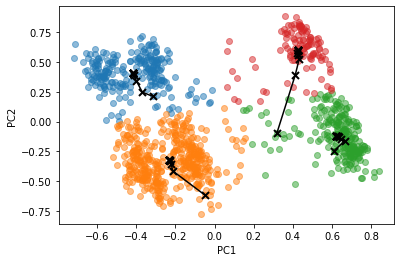

In [10]:
K = 4
initial_centroids = initializeCentroids(pca_result, K)
centroids, cIndex = kMeans(pca_result, initial_centroids, 10)

Looks good! We now see the 4 clusters highlighted in different colours and the path the algorithm took to find the center of the cluster.


*Disclaimer: Running the algorithm not always provides the perfect centroid selection. This is one of the main downsides of K-means. Running the algorithm the clusters might look like this:*

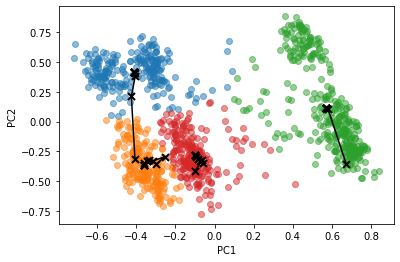

In [14]:
Image(filename='Pic3.png') #figure 3

#### Utilizing the K-means algorithm for outlier detection

The next function calculates all distances between a point and its respective centroid (We used Euclidean distance for this simple presentation, further discussion later).

In [11]:
def distance_from_center(pc1, pc2, label):
    '''
    Calculates the Euclidean distance between a data point and the center of its cluster.
    '''
    center_pc1 =  centroids[label,0]
    center_pc2 =  centroids[label,1]
    distance = np.sqrt((pc1 - center_pc1) ** 2 + (pc2 - center_pc2) ** 2)
    return np.round(distance, 3)

# Create new columns: label, distance
data_pca['label'] = cIndex
data_pca['distance'] = distance_from_center(data_pca.PC1, data_pca.PC2, data_pca.label)

As a dynamic threshold we decided that every point that is further away than the *Mean + 2 x Standard Deviation* from its centroid, will be labeled as an outlier.

In [12]:
pred = data_pca.copy()
pred['prediction'] = np.nan

for l in range(4):
    a = pred.loc[pred['label'] == l, 'distance']
    N_l = pred.label.value_counts()[l]
    mu = a.sum()/N_l
    std_dev = np.sqrt((sum((a - mu)**2))/N_l)
    threshold = mu + (2*std_dev)
    pred['prediction'] = pred['distance'].apply(lambda x: 1.0 if x - threshold > 0 else 0.0)
pred

,PC1,PC2,label,distance,prediction
0,-0.210673,-0.318047,1,0.020,0.0
1,0.628940,-0.295789,2,0.178,0.0
2,-0.433583,0.508853,0,0.100,0.0
3,0.174521,0.110789,2,0.502,1.0
4,-0.077895,-0.445691,1,0.195,0.0
...,...,...,...,...,...
995,-0.174080,-0.542635,1,0.226,0.0
996,0.640441,-0.095204,2,0.029,0.0
997,0.631134,-0.001717,2,0.116,0.0
998,0.353320,-0.139513,2,0.270,0.0


#### Visualization of the data with the detected outliers
The circles indicate detected outlier.

29 data points have been classified as outliers


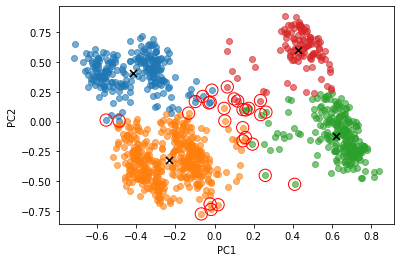

In [13]:
# Extract outliers as an array
outliers = pred[pred['prediction'] == 1]
outliers_plot=outliers.iloc[:,:2].values

fig = plt.figure()
# plotting initial data
for k in range(4):
    plt.scatter(pca_result[(cIndex == k),0], pca_result[(cIndex == k),1], alpha = 0.6)
# plotting red ovals around outlier points
plt.scatter(*zip(*outliers_plot),marker='o',facecolor='None', edgecolor='r',s=150);
# plotting centers as black x
plt.scatter(*zip(*centroids),marker='x',facecolor='black',s=50);

plt.xlabel("PC1")
plt.ylabel("PC2")
print(len(outliers), 'data points have been classified as outliers')

Again, the visualization helps to determine if the results make sense. In this case the detected outliers seem very reasonable. In case of badly placed centroids as mentioned before the plot might look more like this: 

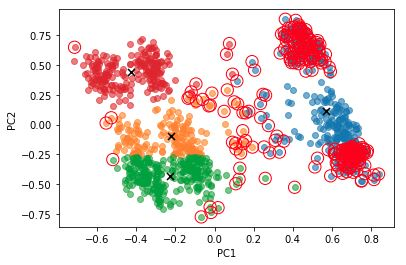

In [18]:
Image(filename='Pic4.JPG') #figure 4

We could immediatly tell that the clusters are placed badly. However, if we would use a more dimensional input for the K-Means algorithm it would not be as trivial to see if the output makes sense or not.

To sum up the first method, we calculate our introduced key performance scores.

In [14]:
y_pred = pred['prediction'].to_numpy()
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

In [15]:
results = {'Scores kMean': [f1, precision, recall, accuracy]}
results_df = pd.DataFrame(results, index=['F1 Score', 'Precision', 'Recall', 'Accuracy'])
results_df

,Scores kMean
F1 Score,0.356589
Precision,0.793103
Recall,0.230000
Accuracy,0.917000


The Accuracy indicates a good performance. However, the F1 Score is not very promising. Also it has to be noted, in the case that the Centroids are not perfectly set it is likely to have a way worse performance. To further improve the score it would have been possible to use more dimensions running the algorithm. That way we would not loose too much information of the data set. Furthermore, a way to improve the performance would be to compute the outliers by using the Mahalanobis distance as the clusters are elipse shaped.

In practical use it is kind of bad if you have algorithm that you have to run multiple times and hope that one time it works correctly. With that said, we will have a look at more sophisticated models next.

## Autoencoder

Generally, an autoencoder works by compressing input information *x* (encoding phase) to then correctly recreate the input *x'* with the help of the reduced information (decoding phase).

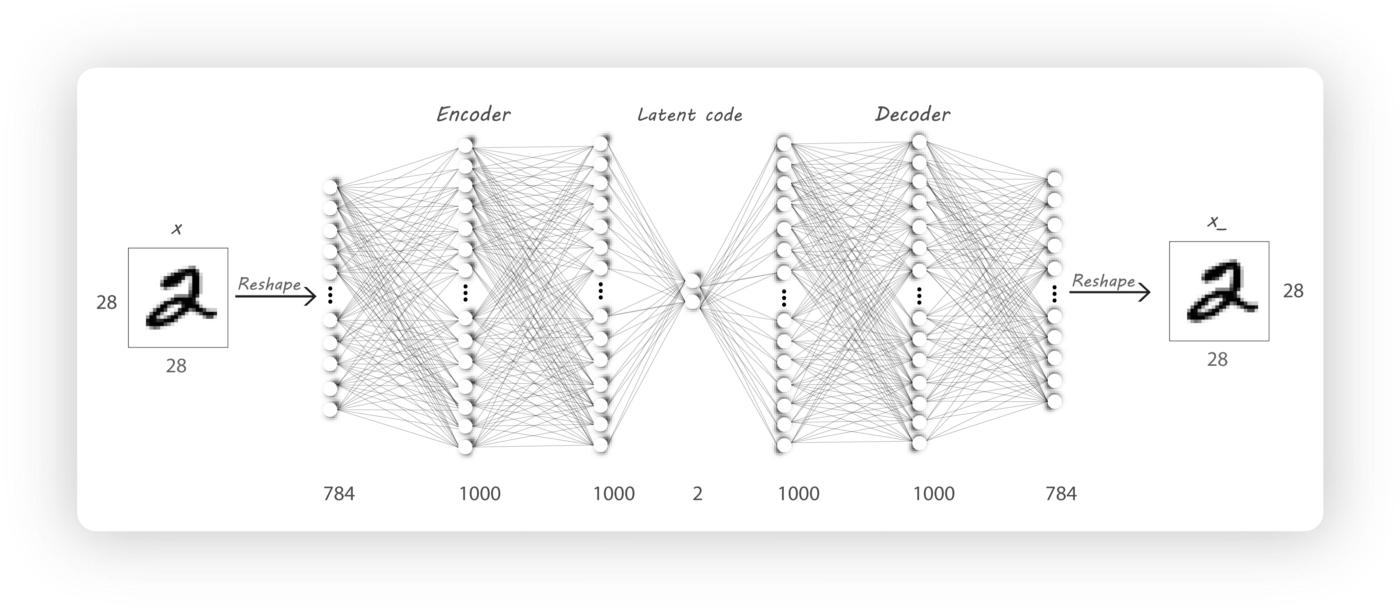

In [21]:
Image(filename='Pic5.png', width=1500) #figure 5

Similar to PCA, the encoder first reduces dimensions of the input information and maps data from its full input space to meaningful lower dimensions so that only the most important information is kept in a latent representation (so-called “bottleneck” or here called *z*). With the help of the reduction, only the most important information is forwarded, while less important information is potentially lost. This technique works in a neural net with hidden layers where typically fewer nodes are used in the subsequent layers up to the bottleneck.

If the function *q* represents the encoder, then we can specify the encoder network by

$$q_\theta(z|x)$$

In a second step, the decoder aims to reverse the encoding step and reconstruct the input data from the latent representation. The weights of the neural net are adapted by backpropagation. Here, the reconstruction loss is the difference between input and reconstructed output data. This reconstruction error serves as a proxy for our anomaly score.

If the decoder is represented by the function *p*, then the decoder net is:

$$p_\theta(x'|z)$$

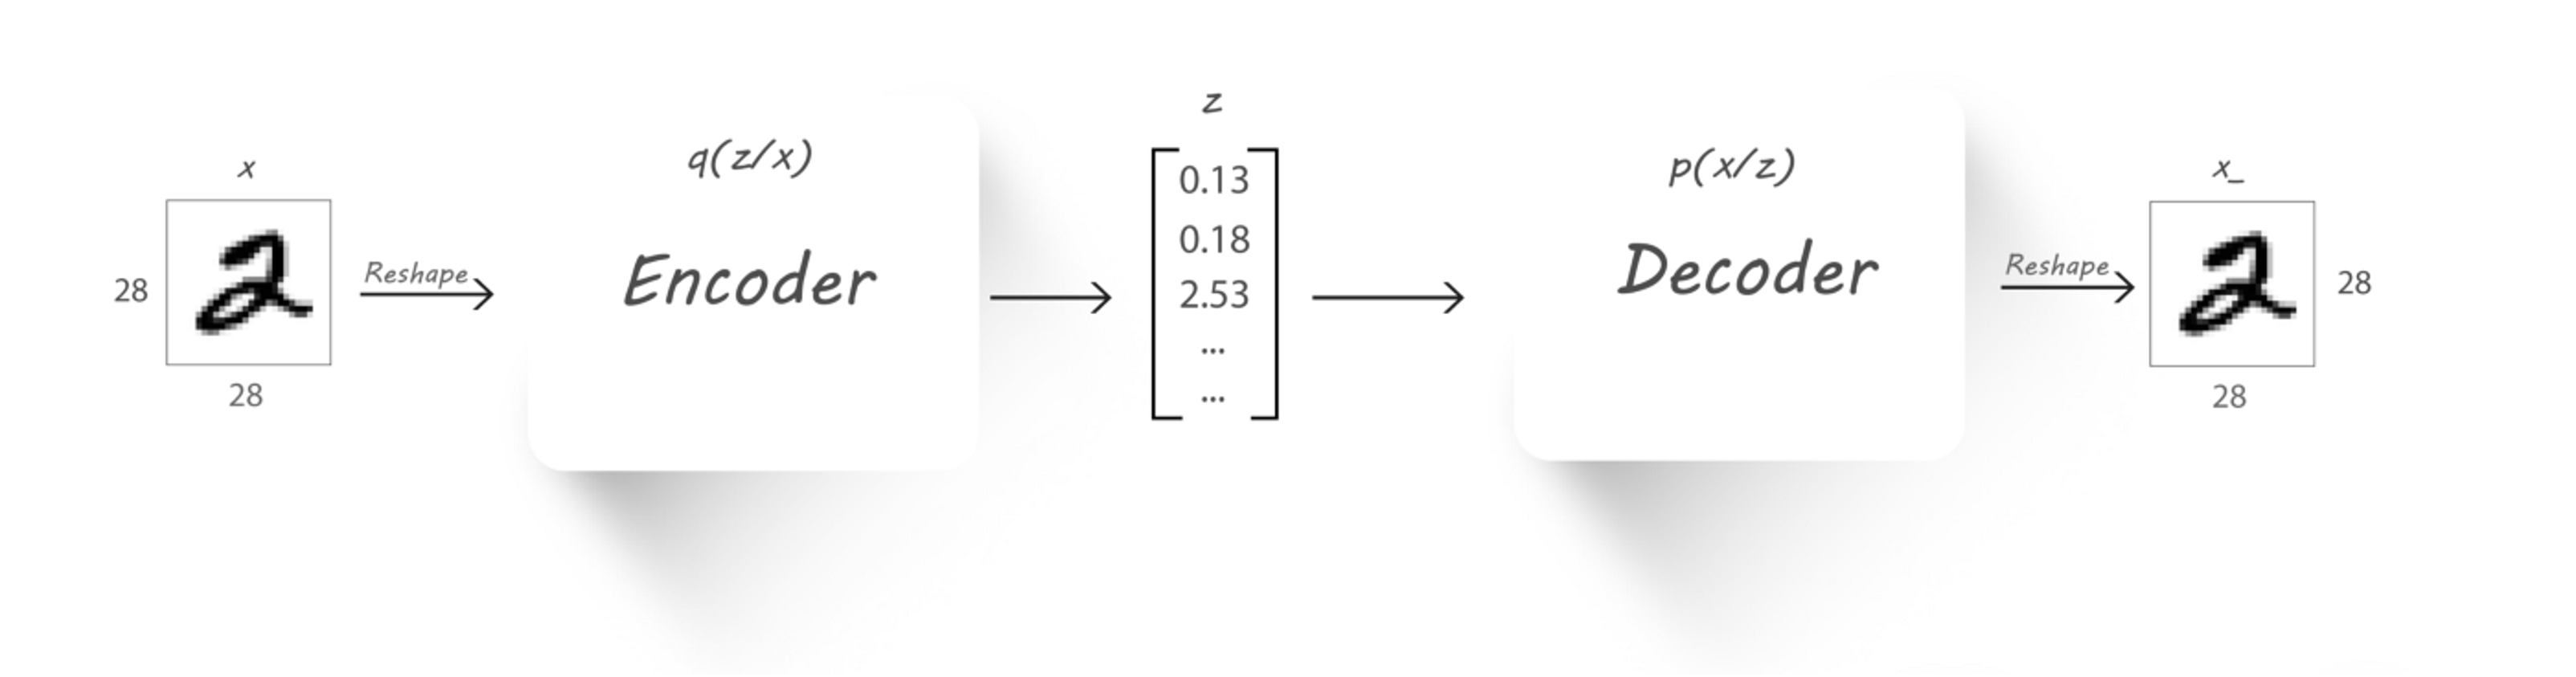

In [18]:
Image(filename='Pic6.png', width=1000) #figure 6

#### Anomaly Detection with an Autoencoder

You can basically split the process of detecting outliers with an autoencoder into two halves. As for most ML algorithms, they are: training & testing.

The training phase will in general consist of the following steps:
* __Train the encoder__: this part of the auto encoder decreases dimensions from the input layer to the code layer. In that process, the neural network learns the essential information patterns of the normal data.
* __Train the decoder__: now the network reconstructs the data from the code layer. The goal is to minimize the difference between the input layer and the output layer.
* __Compute threshold__: choose a threshold of reconstrutcion error to later classify the test data.

These two steps are repeated over and over until we hit a certain goal of low error rate in reconstructing.

Now the testing phase will be built up from the following steps:
* Let the model __*predict* for our test set__ (containing normal and anomalous data). The *prediction* made here is only the reconstruction error so far.
* Use the previously calculated __threshold__ to predict our *real* predictions of class belonging.
* Calculate our __accuracy__ and the other mentioned performance scores with our predictions and the test set.

In practice, it may be helpful to split the data into three subsets to test the threshold as well. The best threshold may vary as the distribution of the outliers changes from dataset to dataset.

In the following section we will implement a basic autoencoder to detect outliers. Note that this proposed class is only to create intuition about how autoencoders can be used for this purpose. A more sophisticated and potentially noise-reducing autoencoder (Neji et al., 2019) with an adapted loss-function, namely an adversarial auto encoder (AEE), was introduced by Schreyer & Sattarov (2019). But for our mini-project, let's start by setting up a small but functioning class with tensorflow:

In [22]:
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units (usually for outlier detection we don't need and want dimensionality reduction)
  
  code_size: int
    Number of units in the middle layer (also called bottle neck)
  
  units_per_layer: list
    Amount of units per layer, outer to inner one (symmetrically used for encoder and decoder)
  """

  def __init__(self, output_units, code_size=8, units_per_layer=[64, 32, 16]):
    super().__init__()
    self.encoder = Sequential([
      Dense(units_per_layer[0], activation='relu'),
      Dropout(0.1),
      Dense(units_per_layer[1], activation='relu'),
      Dropout(0.1),
      Dense(units_per_layer[2], activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(units_per_layer[2], activation='relu'),
      Dropout(0.1),
      Dense(units_per_layer[1], activation='relu'),
      Dropout(0.1),
      Dense(units_per_layer[0], activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

Note, that you could in theory (and should do so in practice) vary the number of layers, dropout rate and sometimes activation function (e. g. leaky relus) as well, but for this case we will leave it simple.

Let us now set up our *detector* and train it with our dataset. A big difference in anomaly detection with autoencoders (in comparison what we are used to in Machine Learning) is that the algorithm actually is not trained with anomalies and thus no *y* data (as in this case the label) is required. This is due to a good reason: We want to train the algorithm to only reconstruct the patterns of the normal data points. Thus, it will have problems with reconstructing outliers which is indicated by their higher reconstruction error. This is - as mentioned - the step in which the outliers are actually detected. We will use our labeled data later to test the outlier detection functionality of the algorithm, since we have the convenience of a labeled dataset.

In [61]:
detector = AutoEncoder(output_units=x_train_scaled.shape[1])

detector.compile(loss='msle', metrics=['mse', 'mae'], optimizer='adam')

history = detector.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=100,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled),
    shuffle=True
)

Epoch 1/100
6/6 [==============================] - 0s 24ms/step - loss: 0.0335 - mse: 0.0724 - mae: 0.2320 - val_loss: 0.0336 - val_mse: 0.0723 - val_mae: 0.2326
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0323 - mse: 0.0697 - mae: 0.2283 - val_loss: 0.0331 - val_mse: 0.0713 - val_mae: 0.2307
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0318 - mse: 0.0689 - mae: 0.2261 - val_loss: 0.0326 - val_mse: 0.0702 - val_mae: 0.2280
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0315 - mse: 0.0674 - mae: 0.2228 - val_loss: 0.0320 - val_mse: 0.0687 - val_mae: 0.2248
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0308 - mse: 0.0663 - mae: 0.2200 - val_loss: 0.0311 - val_mse: 0.0666 - val_mae: 0.2212
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0299 - mse: 0.0639 - mae: 0.2158 - val_loss: 0.0302 - val_mse: 0.0643 - val_mae: 0.2166
Epoch 7/100
6/6 [================

Again, you could use different loss functions (e.g., those represented as metrics) to further improve the performance. But we decided to use the mean squared logarithmic error as it is generally a good starting point. The same applies to the optimizer. 
Furthermore, the number of epochs and the batch size should be changed accordingly to the size and complexity of the dataset. This gets increasingly important as the size of the data set gets bigger due to time reasons.

In the log that is nicely given by tensorflow (when subclassing their model class (and training it)) we can see our first good sign that the training went well: Our loss as well as all the other given metrics decrease mostly steadily. Furthermore, our valuation loss (with the test set) decreases as well. Suprisingly, it is slightly lower than the training loss.

Now let us further evaluate if the training was successful and our autoencoder is able to encode and reconstruct our *normal* data with a simple plot:

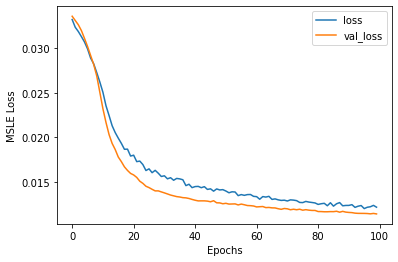

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

Here, we can clearly see that our training was effective: the loss is steadily decreasing and validation loss as well. Our Autoencoder is successfully trained!

Now, the last step is finding a threshold to classify observations as normal or anomalous. Therefore, we look closer at the reconstruction errors as mentioned: The higher the error the higher the likelihood of the observation being an anomaly. This is due to the fact that the autoencoder understands all the *normal* patterns, while anomalous patterns are not understood and thus reconstructed far worse.

A common way to compute the threshold is as follows:

$$threshold = \mu_{reconstruction  error} + 2 * \sigma_{reconstruction error}$$

That means that every observation beyond two sigmas of the mean is classified as an anomaly. Obviously, we will have to compute the threshold based on our training data. Therefore, we use our anomalous training data as well.

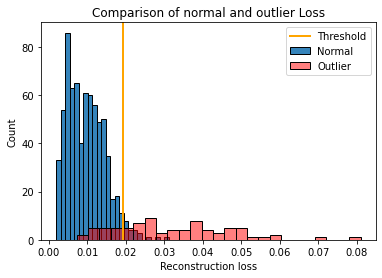

In [63]:
def find_threshold(model, normal_data, outlier_data):
  reconstructions_normal = model.predict(normal_data)
  reconstruction_errors_normal = tf.keras.losses.msle(reconstructions_normal, normal_data)

  reconstructions_outlier = model.predict(outlier_data)
  reconstruction_errors_outlier = tf.keras.losses.msle(reconstructions_outlier, outlier_data)

  threshold = np.mean(reconstruction_errors_normal.numpy()) + 2 * np.std(reconstruction_errors_normal.numpy())
  sns.histplot(reconstruction_errors_normal, bins=25, label='Normal', alpha=0.9)
  sns.histplot(reconstruction_errors_outlier, bins=25, label='Outlier', alpha=0.5, color='red')
  plt.axvline(threshold, color='orange', linewidth=2, label='Threshold')
  plt.xlabel('Reconstruction loss')
  plt.legend(loc='best')
  plt.title('Comparison of normal and outlier Loss')
  return threshold

threshold = find_threshold(detector, x_train_scaled, x_train_scaled_outliers)

We can see that our threshold seems somewhat reasonable in the histplot above. In practice, you may want to choose different thresholds (e. g., predicting a flat top *x%* as outliers) and compare those to a different test set (CV set) to find the optimal threshold for your dataset. Note that you  commonly use your train data (and not your test data) to calculate the threshold.

Now, we need our model to predict the labels for our test data. We use our previously calculated threshold here for prediction. Furthermore, we can then compute the preformance scores for our model.

In [64]:
def get_predictions(model, x_test_scaled, threshold):
  resonstructions = model.predict(x_test_scaled)
  errors = tf.keras.losses.msle(resonstructions, x_test_scaled)
  anomaly_mask = pd.Series(errors) > threshold
  predictions = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
  return predictions

predictions = get_predictions(detector, x_test_scaled, threshold)

f1 = f1_score(predictions, y_test)
accuracy = accuracy_score(predictions, y_test)
precision = precision_score(predictions, y_test)
recall = recall_score(predictions, y_test)

results = {'Scores AutoEncoder': [f1, precision, recall, accuracy]}
results_df_AE = pd.DataFrame(results, index=['F1 Score', 'Precision', 'Recall', 'Accuracy'])
results_df_AE

,Scores AutoEncoder
F1 Score,0.857143
Precision,0.900000
Recall,0.818182
Accuracy,0.970000


We can see that we (easily) outperformed K-means. But before discussing the results later on, let's have a look at our third method:

## Feature Bagging

Ensemble methods are a comfortable invention. Especially, when they act a bit like a kit - they can be very modular and it is easy to change parts of the _algorithm_, making it possible to use the same framework for many different applications.
Looking back at what we know so far as __Ensemble methods__, one might start wondering, "What are they talking about? Random Forests... there was not much to be changed... That was just different trees, all trained the same way."

So, let's get right into the algorithm, the framework and everything that's needed.

__Feature bagging__, what does that even mean? Bagging, short for Bootstrap aggregating, is - simply put - a method where different models predict an outcome and then their predictions are combined in some way in order to reach a final prediction. 
Feature Bagging is a version of Bagging where different features are used for each model.

Enough talking, let's start looking at the code and we'll explain the algorithm as we go.

In [65]:
class Combine(Enum):       
    @staticmethod
    def __avg(as_ts):
        as_final = np.sum(as_ts, axis=0)
        return as_final / len(as_ts)
    
    AVERAGE = __avg
    
class Distance(Enum):
    MANHATTEN = 1
    EUCLIDEAN = 2

In [66]:
class FeatureBagging:
    
    def __init__(self, s, t, c=Combine.AVERAGE, **kwargs):
        self.s = s
        self.t = t
        self.c = c
        self.algargs = kwargs
    
    
    def framework(self) -> np.ndarray:
        """
        Runs the feature bagging framework with the parameters set when initializing the object
        
        Returns the final anomaly score vector
        """
        s = self.__normalize(self.s)
        
        d = len(s.columns)
        as_ts = np.empty([self.t, len(s.index)])
        
        for i in range(self.t):
            n_t = random.randint(d / 2, d - 1)
            s_t = s.sample(n=n_t, axis='columns')
            as_t = self.__init_and_run_alg(s_t)
            as_ts[i] = as_t
        
        self.as_final = self.c(as_ts)
        return self.as_final
            
    def predict(self, threshold=1.2) -> np.ndarray:
        """
        Calculates a prediction for each sample by comparing the anomaly score to the threshold. 
        If AS >= threshold --> 1 = anomaly
        
        Returns the prediction vector
        """
        return (self.as_final >= threshold).astype(int)
    
    def confusion_matrix(self, y_true: np.ndarray, threshold=1.2):
        """
        Calculates the confusion matrix
        [[True positives    False positives]
         [False negatives   True negatives]]
         
        :param y_true: The real target vector. 1 = anomaly, 0 = not anomaly
         
        Returns the confusion matrix and each of it's components in the order tp, fp, fn, tn
        """
        result = pd.DataFrame({'y_true': y_true, 'y_pred': self.predict(threshold)})
        tp = len(result[((result['y_true'] == 1) & (result['y_pred'] == 1))])
        fn = len(result[((result['y_true'] == 1) & (result['y_pred'] == 0))])
        fp = len(result[((result['y_true'] == 0) & (result['y_pred'] == 1))])
        tn = len(result[((result['y_true'] == 0) & (result['y_pred'] == 0))])
        
        return np.array([[tp, fn], [fp, tn]]), tp, fp, fn, tn
    
    def evaluate(self, y_true: np.ndarray, prnt=False, threshold=1.2):
        """
        Calculates and prints a bunch of evaluation metrics including the confusion matrix
        
        :param y_true: The real target vector. 1 = anomaly, 0 = not anomaly
        :param prnt: Prints the metrics to stdout
        
        Returns Accuracy, Precision, Recall, Fall-out, F1 score and the confusion matrix in this order
        """
        cm, tp, fp, fn, tn = self.confusion_matrix(y_true, threshold)
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        recall = tp / (tp + fn)
        fallout = fp / (fp + tn)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * recall) / (precision + recall)
        
        if(prnt):
            print('Confusion Matrix:\n', cm)
            print('Accuracy:', accuracy)
            print('Detection Rate (Recall): ', recall)
            print('False Alarm Rate (Fall-out):', fallout)
            print('Precision:', precision)
            print('F1:', f1)
        
        return accuracy, precision, recall, fallout, f1, cm
    
    def __normalize(self, s: pd.DataFrame) -> pd.DataFrame:
        """
        Min Max Scales a dataset.
        
        Returns the scaled dataframe
        """
        x = s.values
        min_max_scaler = MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        s = pd.DataFrame(x_scaled)
        return s
    
    def __init_and_run_alg(self, s: pd.DataFrame) -> np.ndarray:
        """
        Extracts the important arguments from self.algargs and setsup the algorithm to run for an iteration
        
        :param s: The Dataset that should be used for this iteration
        
        Returns the anomaly score vector for this iteration
        """
        k = self.algargs.get('k', None)
        o_t = LocalOutlierFactor(s.to_numpy(), k, Distance.MANHATTEN)
        return o_t.lof(list(range(len(s))))

The general idea is to run an anomaly detection algorithm on a random subset of features and get a resulting _anomaly_score_ for each data point. The higher this score, the more likely it is anomalous. Then repeat for a certain number of iterations and in the end combine the scores. The notation for the anomaly score of sample __i__ in iteration __t__ is $AS_t(i)$ 

First of all, what are the inputs?
- **S**et - This is the dataset that should be used
- __T__ - How many iterations will we run? 
- **C**ombine - What method is used to combine the scores after all iterations are finished running?
- kwargs - all remaining arguments that will be needed for the anomaly detection algorithm that "powers" this framework. 

Hidden in these bulletpoints, there are already 2 modules that can willingly be changed. The first one is the __engine__ - the anomaly detection algorithm that runs and does the actual hard work. The second one is the method of combination. The arguably easiest combining method is to just take the average of all iterations. 
In the small cell before the last cell, we can see one way of implementing this interchangeability (Distance will be needed later. We thought, we'd just put that enum in the same cell with the combine enum, then we got it out of the way). The combine enum is a bit useless in this case (being an enum class) since we only implemented one combine method, we still wanted to do it this way in order to demonstrate how multiple options could be implemented.

---

Okay, now for real - what happens?
1. We should use a normalized dataset --> step 1, normalize the dataset
2. For each t  
    2.1. Randomly pick a number $ N_t $ between d/2 and d-1 where d is the number of dimensions in the dataset.  
    2.2. Without replacement, randomly pick $ N_t $ features from the dataset  
    2.3. Run the anomaly detection algorithm on that subset  
    2.4. The output of the algorithm is $ AS_t $, the anomaly score vector of iteration __i__  
3. Combine the anomaly score vectors $ AS_t $ into a final anomaly score vector $ AS_{FINAL} $

All of this happens in the method _framework_.
Now, in order to get an actual prediction from these scores we need to choose a threshold at which we flip the switch and call a sample an anomaly. 
But before we can do that, let's actually have a look at the algorithm we used for this work. 

---

We decided to use **Local Outlier Factor** (LOF) as our algorithm.
It's not entirely trivial, but it's rather easy to understand the broad concept. Contrary to other algorithms, LOF - as the name states - outputs a factor instead of a definite prediction. Let's take a quick dive into what that factor means and how it's calculated.

LOF is a density based outlier detection algorithm. This makes it quite a bit more potent for the use case outlier detection than distance-based algorithms like K-Means.
Even though our implementation of K-Means does include the radius of a cluster in its evalutation, it completely disregards the shape of a cluster. This fact can lead to very weird predictions if the centroids converge to different local minima (as can be seen in the following image that you already saw in the K-Means part).

Other distance based approaches, that might only look at the distance between points can run into the following problem:
Depending on the distance between points in a cluster, a point with distance d to the nearest neighbor could be classified as outlier or not in different cases. As can be seen in the next image, the distance between p2 and its nearest neighbor is the same as the distance between p3 and its nearest neighbor. However, p2 clearly looks like an outlier while p3 very much fits into cluster C1.

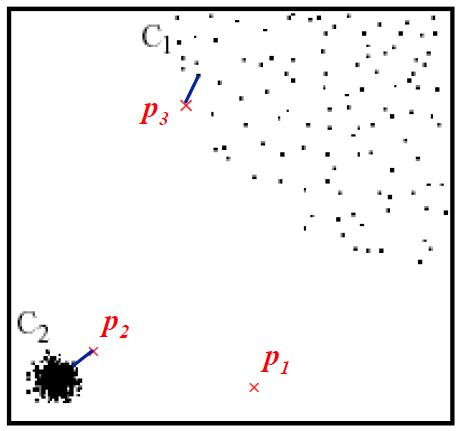

In [31]:
Image(filename='Pic7.jpg') #figure 7

Now, that we know why we might need a density-based approach, how does it actually work?
There are 4 essential concepts that need to be briefly explained:
1. K-Distance and K-Neighbors
2. Reachability Distance (RD)
3. Local Reachability Density (LRD)
4. Local Outlier Factor (LOF)

### 1. K-Distance and K-Neighbors

The _K-Distance_ of a point P $ Kd_k(P) $ is the distance between itself and its K-th nearest neighbor. The K-Neighbors of a point P $ N_k(P) $ are all points with a distance less than or equal to the K-Distance. Each point has at least K K-Neighbors, but can have more. We call the amount of K-Neighbors of a point P $|N_k(P)|$.

The distance measure can be chosen by the user. In the enum distance earlier we have defined two distance measures that can be used. More could be implemented. 

### 2. Reachability Distance (RD)

The reachability distance is defined as the maximum of K-distance of $X_j$ and the distance between the two points. In other words, if $X_i$ is a K-Neighbor of $X_j$, then $RD(X_i, X_j) = Kd_k(X_j)$, otherwise $RD(X_i, X_j) = d(X_i, X_j)$

$$ RD(X_i, X_j) = max(Kd_k(X_j), d(X_i, X_j)) $$

### 3. Local Reachability Density (LRD)

The LRD is the inverse of the average RD of a point P from $N_k(P)$

$$ LRD_k(P) = \frac{1}{\sum_{X_j \in N_k(P)}\frac{RD(P, X_j)}{|N_k(P)|}} $$

### 4. Local Outlier Factor (LOF)

LOF of P is the ratio of the average LRD of $N_k(P)$ to the LRD of P.

$$ LOF_k(P) = \frac{\sum_{X_j \in N_k(P)}LRD_k(X_j)}{|N_k(P)|}*\frac{1}{LRD_k(P)} $$

Intuitively, an LOF less or equal to 1 means, that the point is likely not an outlier. The higher the LOF, the more likely a point is an outlier.

In [67]:
class LocalOutlierFactor:  
    def __init__(self, x, k, distance_measure):  
        self.KD = self.KDistance(x, k, distance_measure)
        self.LRD = self.LocalReachabilityDensity(self)
    
    
    def lof(self, i):
        """
        Calculates the Local Outlier Factor for point i/all points in i
        
        :param i: index of one sample or list of indices of multiple samples
        
        Returns list of LOFs
        """
        i = np.atleast_1d(i)
        
        neighbors = self.KD.neighbor_points()
        
        return [np.average(self.LRD.local_reachability_density(neighbors[ii])) / self.LRD.local_reachability_density(ii) for ii in i]
        
    
    class KDistance:
        def __init__(self, x, k, distance_measure):
            self.x = x
            self.k = k
            self.d = distance_measure.value
            self.distance_matrix = self.__distance_matrix()
            
        def __distance_matrix(self) -> np.ndarray:
            """
            Calculates the distance matrix of the entire dataset using the 
            distance measure specified when initializing the object 
            """
            return distance_matrix(self.x, self.x, self.d)
            
        def k_distance(self) -> np.ndarray:
            """
            If not executed before, calculates the K-Distances of all samples, stores them and returns them
            
            Returns array of K-Distances of all samples
            """
            if not hasattr(self, 'kd'):
                self.kd = np.sort(self.distance_matrix, axis=1)[:, self.k]
            return self.kd
            
        def k_neighbors(self) -> pd.DataFrame:
            """
            If not executed before, builds a matrix from the distance matrix and removes all distances outside the k-distance of
            each point - rowwise.
            E.g. In the first row will only be values left that are smaller then k_distance()[0]
            
            Returns matrix of distances smaller than k distance of a sample. Rowwise.
            """
            if not hasattr(self, 'kneighbors'):
                kd = self.k_distance()
                m = pd.DataFrame(self.distance_matrix)
                kd = pd.Series(kd)   
                self.kneighbors = m[m.le(kd, axis=0)]
                self.kneighbors.replace(0, np.nan, inplace=True)
            return self.kneighbors
        
        def neighbor_points(self) -> dict:
            """
            If not executed before, builds a dictionary. Keys are the indices of the samples, 
            values are the indices of their neighbors
            
            Returns the dictionary of neighbor indices
            """
            if not hasattr(self, 'neighborpoints'):
                kn = self.k_neighbors().to_numpy()
                self.neighborpoints = {k: [i for i in range(len(self.x)) if not math.isnan(kn[k, i])] for k in range(len(self.x))}
                   
            return self.neighborpoints
        
        def k_neighbors_count(self) -> np.ndarray:
            """
            If not executed before, builds a list with neighbor counts for all samples
            """
            if not hasattr(self, 'kneighborscount'):
                kn = self.k_neighbors()
                self.kneighborscount = (kn.sum(axis=1) - 1)
            return self.kneighborscount.to_numpy()
        
    class LocalReachabilityDensity:
        
        def __init__(self, LOF):
            self.LOF = LOF
        
        
        def reachability_distance(self, i, j):
            """
            Calculates the reachability distance of the sample with index i from the point/points with index/indices j
            
            :param i: index
            :param j: index or array of indices
            
            Returns list of reachability distances
            """
            return np.maximum(self.LOF.KD.k_distance()[j], self.LOF.KD.distance_matrix[i, j])
        
        def local_reachability_density(self, i):
            """
            Calculates the LRD of the sample or samples with index i or indices in i
            
            :param i: index or array of indices
            
            Returns the LRD of sample i if i is an int
            Returns a list of LRDs if i is a list of integers
            """
            i = np.atleast_1d(i)
            
            neighbors = self.LOF.KD.neighbor_points()
            
            result = [1 / np.average(self.reachability_distance(ii, neighbors[ii])) for ii in i]
            if len(result) == 1:
                result = result[0]
            return result

This implementation of the algorithm favors smaller datasets over larger datasets since it uses a lot of space storing intermediate results instead of computing them on a just-in-time basis, e.g., the distance matrix of the entire dataset is computed at the very beginning of the LOF algorithm; The K-distance, K-neighbors and the number of K-neighbors of each sample are also stored.

We would argue that this way the algorithm runs faster than if everything needs to be computed every time it is needed. However we only implemented the algorithm once and thus did not test different possibilities.
This way, LOF has it is limits though. We cannot put a finger on where problems start exactly, we tested a 50,000 sample dataset once and the distance matrix for this sample would require $ 50,000 * 50,000 * 8 bytes (float) = 20 GB = 18.6 GiB$ - so that definitely didn't work.

Let's stop talking about 20 GB distance matrices though and start looking at our 1000 sample dataset and how well the algorithm is able to identify outliers.
Therefore, we will declare some utility functions first.

In [68]:
def translate(row) -> int:
    """
    Returns an index for a prediction indicating the place in the confusion matrix
    
    Returns 
    - 0 for a True Positive
    - 1 for a False Positive
    - 2 for a False Negative
    - 3 for a True Negative
    """
    if row['y_true'] == 1 and row['y_pred'] == 1: #true positive
        return 0
    if row['y_true'] == 0 and row['y_pred'] == 1: #false positive
        return 1
    if row['y_true'] == 1 and row['y_pred'] == 0: #false negative
        return 2
    if row['y_true'] == 0 and row['y_pred'] == 0: #true negative
        return 3
    
def draw_multi_dim_outlier_plot(x: pd.DataFrame, results: pd.DataFrame, threshold: float):
    """
    Draws 2 dimensional scatter plots of all feature combinations.
    Different colors are used to code where in the confusion matrix a point ended up
    Also draws a scatter plot of all LOF scores, color if they're actually an outlier or not. This plot includes
    a vertical line where the threshold is placed.
    
    :param x: Dataset
    :param results: DataFrame with the following columns (ordered the same way as the samples in x):
                'score': the LOF of the sample
                'color': the index where the sample is placed in the confusion matrix
                'y_true': the target outcome (anomaly/not anomaly)
    
    """
    n = len(x.columns)
    
    fig = plt.figure(figsize=(50, 50))
    for i in range(n):
        for j in range(i + 1, n):
            ax = plt.subplot2grid(shape=(n + 1, n), loc=(i, j), fig=fig)
            ax.scatter(x[x.columns[i]], x[x.columns[j]], c=results['color'])
            
    ax = plt.subplot2grid(shape=(n + 1, n), loc=(n - 1, 0), colspan=n, rowspan=2, fig=fig)
    ax.scatter(results['score'], np.random.rand(len(results)), c=results['y_true'])
    ax.vlines(threshold, ymin=0, ymax=1)
    plt.show()
    
def run_analysis_on_dataset(x: pd.DataFrame, y: pd.Series, include_plot=True, iterations=15, k=10, threshold=1.2) -> FeatureBagging:
    """
    Runs a Feature Bagging analysis analysis on a dataset and prints some evaluation KPIs
    Can be configured to run draw_multi_dim_outlier_plot and plot the results. If this feature is used, 10 random features 
    are selected and passed to the draw method.
    
    :param x: Dataset
    :param y: Vector of 0s and 1s indicating if a sample is an outlier or not
    :param include_plot: Calls draw_multi_dim_outlier_plot if true
    :param iterations: How many iterations the feature bagging will run for
    :param k: k that will be used for K-Distance and K-Neighbors
    :param threshold: the LOF at which a prediction will swap from 0 to 1 (non-anomaly to anomaly)
    
    Returns the evaluation metrics
    """
    fb = FeatureBagging(x, iterations, Combine.AVERAGE, k=k)
    fb.framework()
    metrics = fb.evaluate(y_true=y, prnt=True, threshold=threshold)
    
    bagging_res = pd.DataFrame({'y_true': y, 'y_pred': fb.predict(threshold)})
    bagging_res['color'] = bagging_res.apply(lambda row: translate(row), axis=1)
    bagging_res['score'] = fb.as_final
        
    if include_plot:
        draw_multi_dim_outlier_plot(x.sample(n=10, axis='columns'), bagging_res, threshold)
    
    return metrics

Before starting the analysis, let's spend a quick thought on the parameters. 

The _iterations_ (t) parameters controls how many unique feature combinations we can get. Generally, if there are more features in the original dataset, it makes sense to use a higher number of iterations. Lazarevic and Kumar (2005) use t = 50 for all of their datasets - including datasets with around 15 up to around 620 features. For the dataset with only 6 features, they use 10 iterations. 
For our dataset with 10 features, let us pick 15 iterations for starters and see how we do.

The k parameter controls how many points each point's LDR is compared to in order to compute the LOF. It would make sense to set k somewhere around what we would consider a cluster. This number can drastically change depending on how big the dataset is.
Literature also suggests using not a single value for k but rather a range of k's between the minimum cluster size, where we start to believe that the similar behaviour is not random, and a number where we believe that the number of points behave similarly.
This sounds weird without an example, but since our data is synthetic anyway and does not include much causality that we could draw conclusions from, we are not going to go deeper into this.
In the sklearn documentation of LOF, we can find that they use k = 20 as a default value. 
There are other sources saying as long as the size of the dataset permits it, k should not be less than 10.
Since our dataset is rather small with only 1000 samples, let's stick with these 10 and see how it goes.

There is one more "parameter" we should talk about before finally running all of the code. Well, this is going to be a tough one. Strictly speaking, an LOF > 1 is considered an outlier. But actually implementing that looks a bit stupid. Obviously, there will be points with a tiny bit less density than their neighbors, but they are far from being an outlier. _Threshold_ controls how different a sample's density is allowed to be before being considered an outlier. 
In our testing, 1.2 stood out to work well as a starting point for a threshold. It seemed like in higher dimensional datasets a slightly higher threshold might be a good choice.

Confusion Matrix:
 [[ 94   6]
 [ 17 883]]
Accuracy: 0.977
Detection Rate (Recall):  0.94
False Alarm Rate (Fall-out): 0.01888888888888889
Precision: 0.8468468468468469
F1: 0.8909952606635071


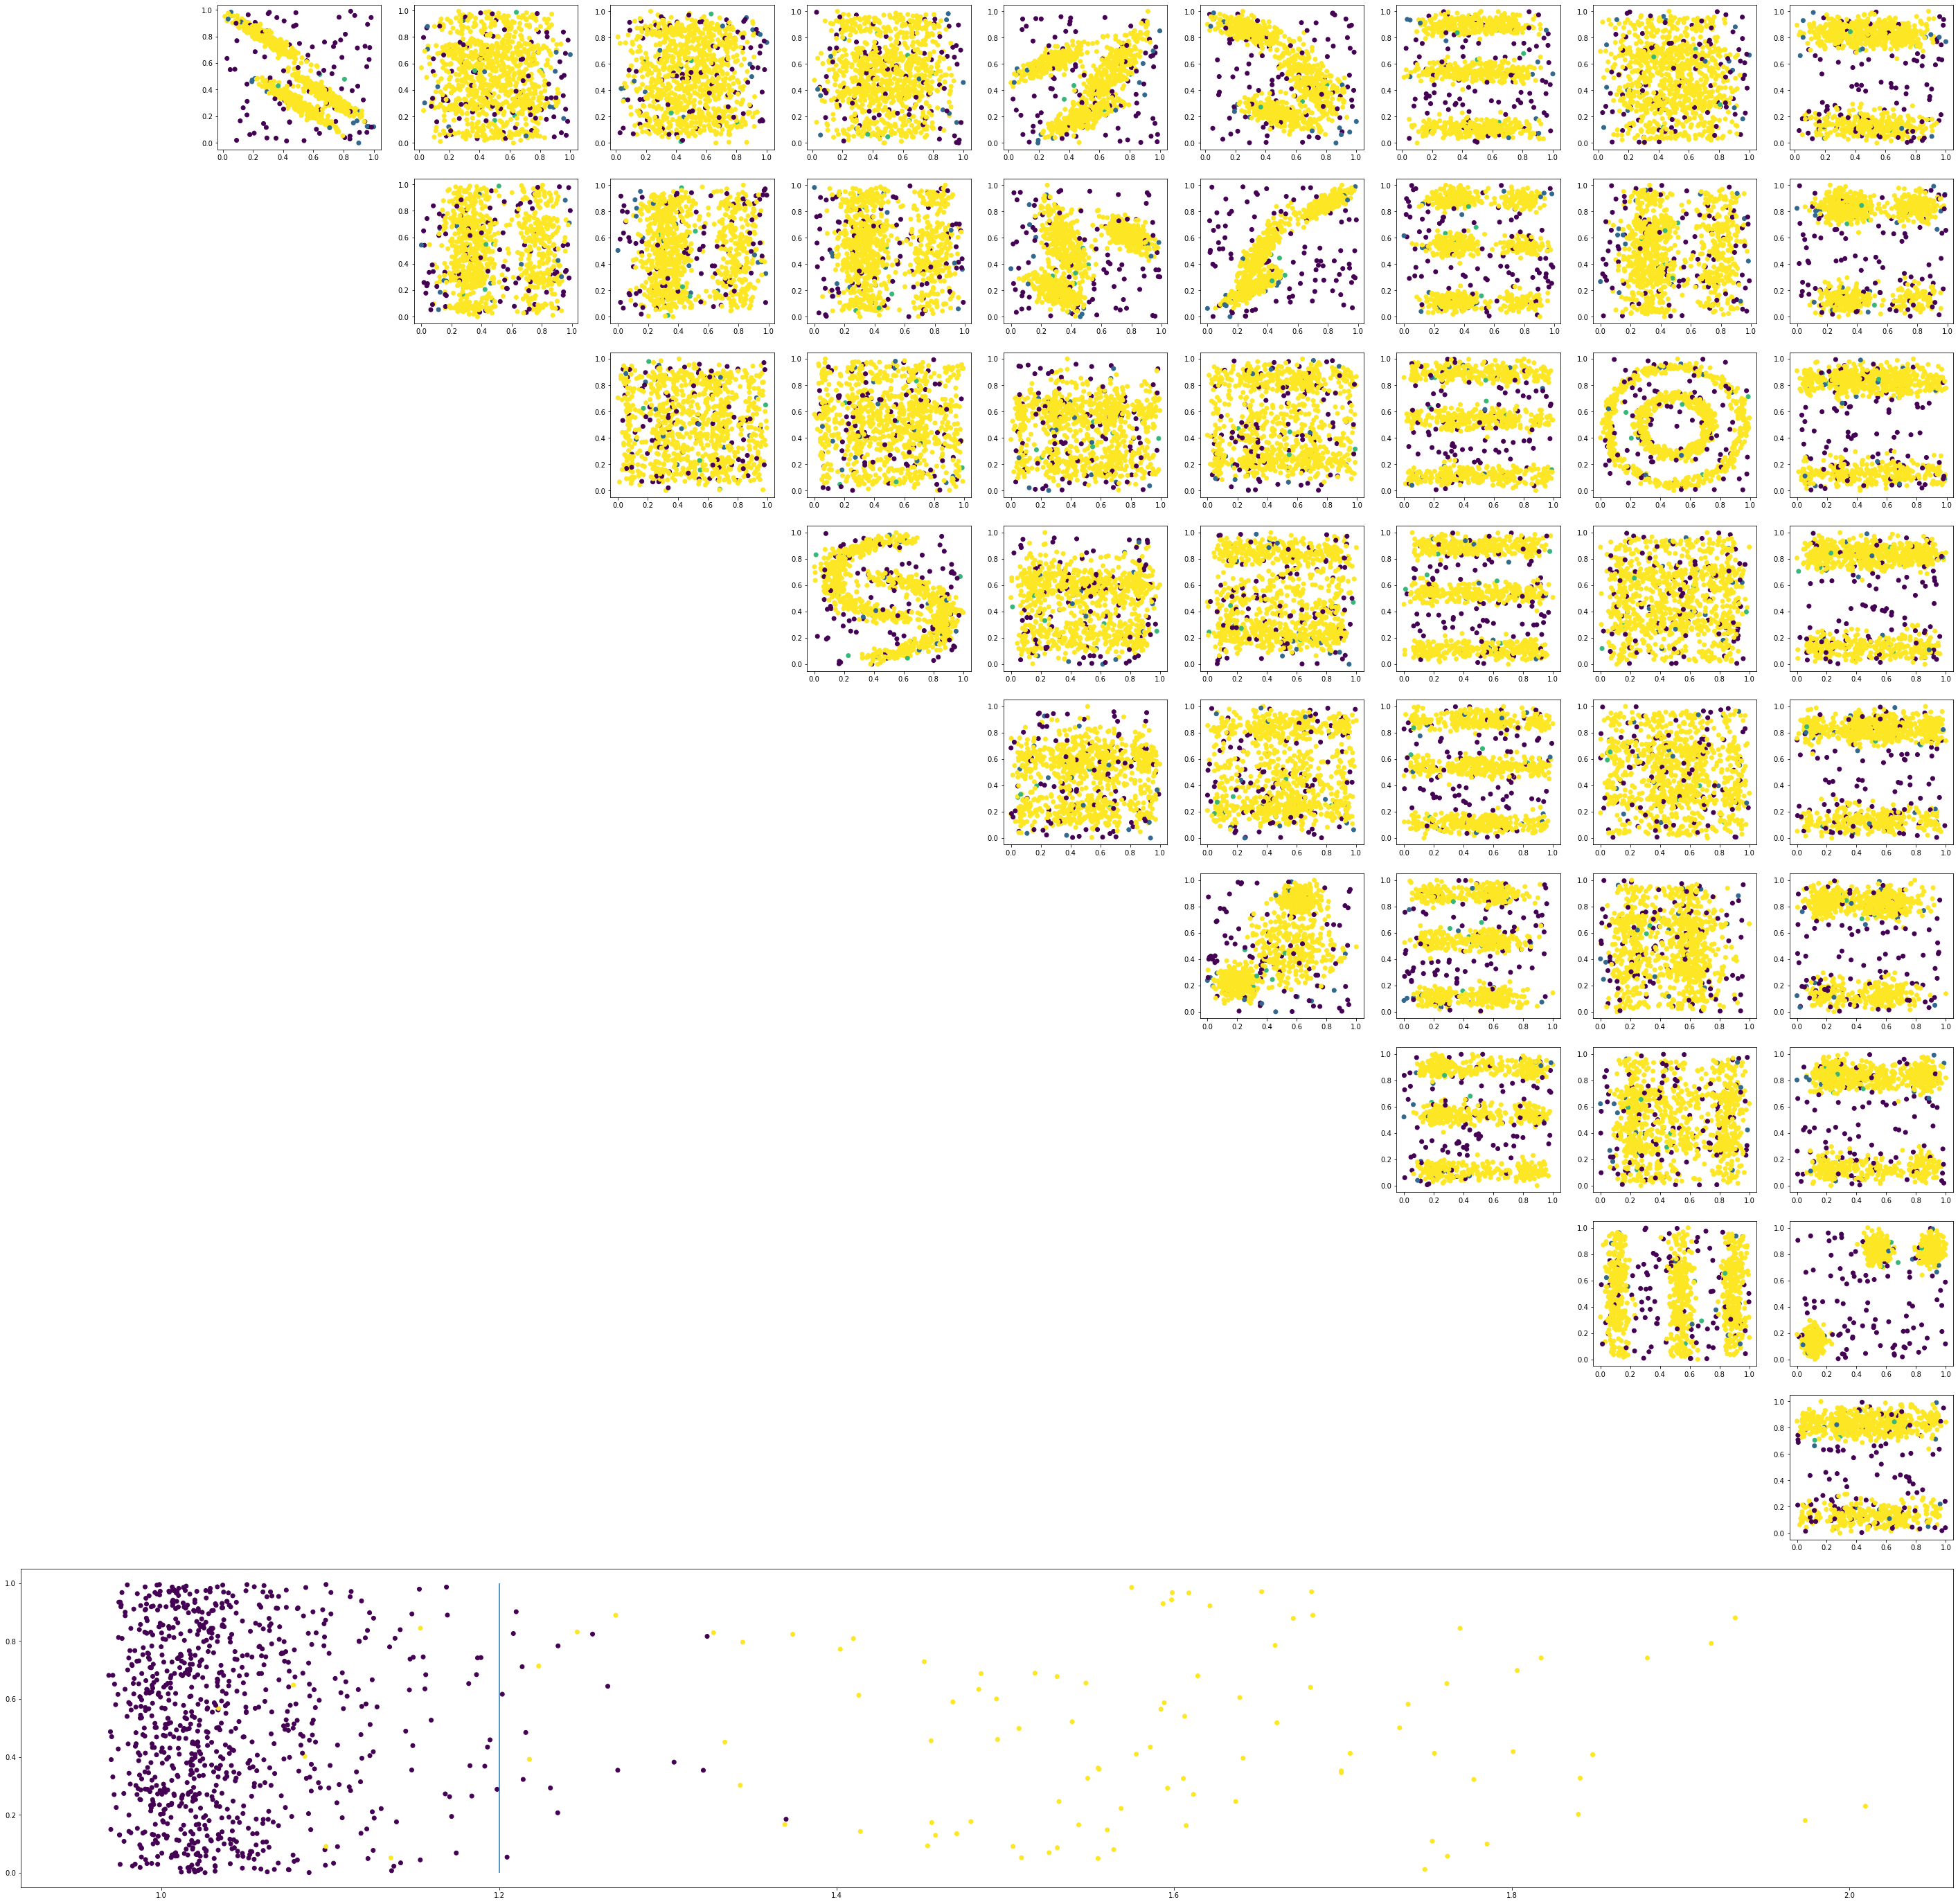

Runtime: 8.207711935043335


In [69]:
begin = time.time()
acc, prec, recall, fallout, f1, _ = run_analysis_on_dataset(features, y_true, True, iterations=15, k=10, threshold=1.2)
print('Runtime:', time.time() - begin)

In [71]:
results = {'Scores Feature Bagging': [f1, prec, recall, acc]}
results_df_FB = pd.DataFrame(results, index=['F1 Score', 'Precision', 'Recall', 'Accuracy'])
results_df_FB

,Scores Feature Bagging
F1 Score,0.890995
Precision,0.846847
Recall,0.940000
Accuracy,0.977000


Again, we are easily outperforming K-means and even outperform the autoencoder slightly.

## Conclusion
To draw a conclusion, it may be worth recalling our chosen metrics:

$$ F1 = 2 *\frac{Precision * Recall}{Precision + Recall} $$

$$ Precision = \frac{TP}{TP+FP} $$

$$ Recall = \frac{TP}{TP+FN} $$

$$Accuracy = \frac{TN+TP}{TN+FP+TP+FN} $$

Now after explaining the methods we applied, let us look at the results for our predfined metrics:

In [72]:
pd.concat([results_df, results_df_AE, results_df_FB], axis=1)

,Scores kMean,Scores AutoEncoder,Scores Feature Bagging
F1 Score,0.356589,0.857143,0.890995
Precision,0.793103,0.900000,0.846847
Recall,0.230000,0.818182,0.940000
Accuracy,0.917000,0.970000,0.977000


##### Shallow vs. deep approaches
We can conclude that for high-dimensional, i. e. our synthetic data set, shallow approaches do not do the job properly and thus the autoencoder and the feature bagging approach outperformed K-means by far. This comes as no big surprise as we compressed the information from the data to apply K-means. Hence, we could not make use of all the information given in contrast to the _deep_ methods which were able to do so.

##### Deep approaches compared
We can see the feature bagging approach outperformed the autoencoder in regard to F1 score. This is due to the fact that the autoencoder seems to focus on precision at it is trained right now. Unsurpsingly, it depends... The end. No but on a serious note, it depends: our models aren't trained perfectly and the scores vary from run to run. Furthermore, one method may be superior for one dataset whilst the other may be superior in another dataset. 

To further evaluate our findings, it would be interesting to apply our approaches to different data sets. Especially for lower dimensional data, it would be interesting to know whether our deep approaches would still outperform K-means as strongly as shown above. Further, we could have a look at different methods or enhance our selected methods, e.g. by extending the autoencoder framework and building e. g. an adversarial autoencoder. Another approach that may be interesting to combine both lateral methods and build a bagging algorithm that utilizes autoencoders.

## Bibliography

### Literature

Abdi, H., & Willian, L. J. (2010). Principal Component Analysis. Wiley Interdisciplinary Reviews: Computational Statistics, 2(4), 433-459. doi:https://doi.org/10.1002/wics.101

Barnett, V., & Lewis, T. (1996). Outliers in statistical data. International Journal of Forecasting, 12(1), 175-176. 

Ben-Gal, I. (2005). Outlier Detection. In O. Malmon & L. Rockach (Eds.), Data Mining and Knowledge Discovery Handbook: A Complete Guide for Practitioners and Researchers. Tel-Aviv University Ramat-Aviv, Tel-Aviv 69978, Israel: Kluwer Academic Publishers.

Hauskrecht, M., Batal, I., Valko, M., Visweswaran, S., Cooper, G. F., & Clermont, G. (2013). Outlier detection for patient monitoring and alerting. Journal of Biomedical Informatics, 46, 47-55. doi:http://dx.doi.org/10.1016/j.jbi.2012.08.004

Hawkins, D. M. (1980). Identification of Outliers.

Jauhiainen, S., Äyrämö, S., Forsman, H., & Kauppi, J.-P. (2019). Talent identification in soccer using a one-class support vector machine. International Journal of Computer Science in Sport, 18(3), 125-136. doi:https://doi.org/10.2478/ijcss-2019-0021

Lazarevic, A., & Kumar, V. (2005). Feature bagging for outlier detection. Paper presented at the Proceedings of the eleventh ACM SIGKDD international conference on Knowledge discovery in data mining, Chicago, Illinois, USA. 

Liu, H., Shah, S., & Jiang, W. (2004). On-line outlier detection and data cleaning. Computers and Chemical Engineering, 28, 1635–1647. 

Neji, H., Nogueras-Iso, J., Lacasta, J., Halima, M. B., & Alimi, A. M. (2019). Adversarial Autoencoders for denoising digitized historical documents: the use case of incunabula. Paper presented at the International Conference on Document Analysis and Recognition Workshops (ICDARW), University of Sfax, National Engineering School of Sfax (ENIS), BP 1173, Sfax, 3038, Tunisia. 

Pawar, A. D., Kalavadekar, P. N., & Tambe, S. N. (2014). A Survey on Outlier Detection Technique s for Credit Card Fraud Detection. IOSR Journal of Computer Engineering, 16(2), 44-48. 

Ruff, L., Kauffmann, J. R., Vandermeulen, R. A., Montavon, G., Samerk, W., Kloft, M., . . . Müller, K.-R. (2021). A Unifying Review of Deep and Shallow Anomaly Detection. Proceedings of the IEEE, 109(5), 756-795. doi:10.1109/JPROC.2021.3052449

Schreyer, M., Sattarow, T., Schulze, C., Reimer, B., & Borth, D. (2019). Detection of Accounting Anomalies in the Latent Space using Adversarial Autoencoder Neural Networks. Paper presented at the 2nd KDD Workshop on Anomaly Detection in Finance, Anchorage, Alaska. 

Williams, G., Baxter, R., He, H., Hawkins, S., & Gu, L. (2002). A Comparative Study of RNN for Outlier Detection in Data Mining_. Paper presented at the 2002 IEEE International Conference on Data Mining,. 

Zimek, A., Schubert, E., & Kriegl, H.-P. (2012). A survey on unsupervised outlier detection in high-dimensional numerical data. Statistical Analysis and Data Mining, 5(5), 363-387. doi:https://doi.org/10.1002/sam.11161


### Pictures

*Figure 1*: https://medium.com/subex-ai-labs/an-introduction-to-outlier-detection-methods-using-python-f2013824a7b7

*Figure 2*: https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/

*Figure 3*: Example for bad clustering (plot was generated in a previous run)

*Figure 4*: Example for bad outlier detection (plot was generated in a previous run)

*Figure 5*: https://towardsdatascience.com/a-wizards-guide-to-adversarial-autoencoders-part-1-autoencoder-d9a5f8795af4

*Figure 6*: https://towardsdatascience.com/a-wizards-guide-to-adversarial-autoencoders-part-1-autoencoder-d9a5f8795af4

*Figure 7*: Lazarevic & Kumar (2005)